In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
from itertools import combinations

In [2]:
json_file = './tests/json/test4.json'
func_name = 'test'
with open(json_file, 'r') as f:
    prog = json.load(f)


In [3]:
prog['functions'][func_name]['body']

{'bb1': {'id': 'bb1',
  'insts': [{'Copy': {'lhs': {'name': 'id4', 'typ': 'Int', 'scope': 'test'},
     'op': {'Var': {'name': '_lo1', 'typ': 'Int', 'scope': 'test'}}}},
   {'Copy': {'lhs': {'name': 'id15',
      'typ': {'Pointer': {'Pointer': {'Struct': 'st'}}},
      'scope': 'test'},
     'op': {'Var': {'name': 'id16',
       'typ': {'Pointer': {'Pointer': {'Struct': 'st'}}},
       'scope': 'test'}}}},
   {'Copy': {'lhs': {'name': 'id17',
      'typ': {'Pointer': {'Pointer': {'Struct': 'st'}}},
      'scope': 'test'},
     'op': {'Var': {'name': 'id15',
       'typ': {'Pointer': {'Pointer': {'Struct': 'st'}}},
       'scope': 'test'}}}},
   {'Load': {'lhs': {'name': '_t35',
      'typ': {'Pointer': {'Struct': 'st'}},
      'scope': 'test'},
     'src': {'name': 'id19',
      'typ': {'Pointer': {'Pointer': {'Struct': 'st'}}},
      'scope': 'test'}}},
   {'Copy': {'lhs': {'name': 'id18',
      'typ': {'Pointer': {'Struct': 'st'}},
      'scope': 'test'},
     'op': {'Var': {'name': 

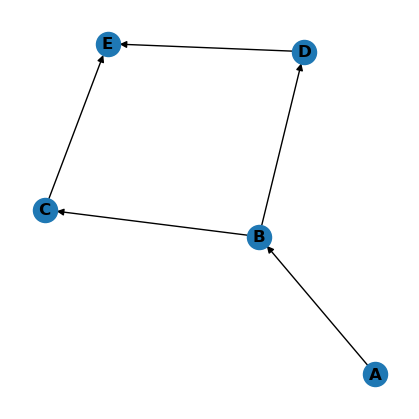

In [4]:
cfg = nx.DiGraph()
cfg.add_nodes_from(['A', 'B', 'C', 'D', 'E'])
cfg.add_edges_from([('A', 'B'), ('B', 'C'), ('B', 'D'), ('C', 'E'), ('D', 'E')])
plt.figure(figsize=(4,4))
nx.draw(cfg, with_labels=True, font_weight='bold')

In [5]:
list(nx.all_simple_paths(cfg, 'A', 'E'))

[['A', 'B', 'C', 'E'], ['A', 'B', 'D', 'E']]

In [6]:
dom_rela = {node: {node} for node in cfg.nodes}
dom_rela_strict = {node:set() for node in cfg.nodes}

def gene_dominators(cfg: nx.DiGraph, entry_node: str = 'entry', strict: bool=False):
    dominators = {node: set() for node in cfg.nodes}
    for node in cfg.nodes:
        if node == entry_node:
            continue
        through_nodes = []
        for path in nx.all_simple_paths(cfg, entry_node, node):
            through_nodes.append(set(path))
        
        dominators[node] = set.intersection(*through_nodes)
    if strict:
        for node in cfg.nodes:
            dominators[node] = dominators[node] - {node}
    else:
        for node in cfg.nodes:
            dominators[node] = dominators[node].union({node})
    return dominators

def gene_dom_rela(cfg: nx.DiGraph, entry_node: str = 'entry', strict: bool=False):
    dominators = gene_dominators(cfg, entry_node, strict)
    dom_rela = {node: set() for node in cfg.nodes}
    for node in cfg.nodes:
        for dom_node in dominators[node]:
            dom_rela[dom_node].add(node)
    return dom_rela

def gene_imm_dominators(cfg: nx.DiGraph, entry_node: str = 'entry'):
    # immediate dominators
    dominators = gene_dominators(cfg, entry_node, True)
    imm_dominators = {node: set() for node in cfg.nodes}
    for node in cfg.nodes:
        for dom_node in dominators[node]:
            if (dominators[node] - {dom_node}).issubset(dominators[dom_node]):
                imm_dominators[node].add(dom_node)
    return imm_dominators

def gene_imm_dom_rela(cfg, entry_node: str = 'entry'):
    imm_dominators = gene_imm_dominators(cfg, entry_node)
    imm_dom_rela = {node: set() for node in cfg.nodes}
    for node in cfg.nodes:
        for imm_dom_node in imm_dominators[node]:
            imm_dom_rela[imm_dom_node].add(node)
    return imm_dom_rela

In [7]:
gene_imm_dominators(cfg, 'A')

{'A': set(), 'B': {'A'}, 'C': {'B'}, 'D': {'B'}, 'E': {'B'}}

In [8]:
gene_imm_dom_rela(cfg, 'A')

{'A': {'B'}, 'B': {'C', 'D', 'E'}, 'C': set(), 'D': set(), 'E': set()}

In [9]:
gene_dominators(cfg, 'A', True)

{'A': set(), 'B': {'A'}, 'C': {'A', 'B'}, 'D': {'A', 'B'}, 'E': {'A', 'B'}}

In [10]:
gene_dom_rela(cfg, 'A', True)

{'A': {'B', 'C', 'D', 'E'},
 'B': {'C', 'D', 'E'},
 'C': set(),
 'D': set(),
 'E': set()}

In [11]:
gene_dominators(cfg, 'A', False)

{'A': {'A'},
 'B': {'A', 'B'},
 'C': {'A', 'B', 'C'},
 'D': {'A', 'B', 'D'},
 'E': {'A', 'B', 'E'}}

In [12]:
gene_dom_rela(cfg, 'A', False)

{'A': {'A', 'B', 'C', 'D', 'E'},
 'B': {'B', 'C', 'D', 'E'},
 'C': {'C'},
 'D': {'D'},
 'E': {'E'}}

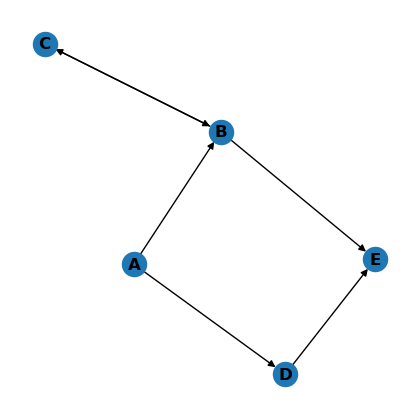

In [13]:
cfg1 = nx.DiGraph()
cfg1.add_nodes_from(['A', 'B', 'C', 'D', 'E'])
cfg1.add_edges_from([('A', 'B'), ('A', 'D'), ('B', 'C'), ('C', 'B'), ('B', 'E'), ('D', 'E')])
plt.figure(figsize=(4,4))
nx.draw(cfg1, with_labels=True, font_weight='bold')

In [14]:
gene_dom_rela(cfg1, 'A', True)

{'A': {'B', 'C', 'D', 'E'}, 'B': {'C'}, 'C': set(), 'D': set(), 'E': set()}

In [15]:
gene_dom_rela(cfg1, 'A', False)

{'A': {'A', 'B', 'C', 'D', 'E'},
 'B': {'B', 'C'},
 'C': {'C'},
 'D': {'D'},
 'E': {'E'}}

In [16]:
gene_imm_dom_rela(cfg1, 'A')

{'A': {'B', 'D', 'E'}, 'B': {'C'}, 'C': set(), 'D': set(), 'E': set()}

In [17]:
gene_dominators(cfg1, 'A', True)

{'A': set(), 'B': {'A'}, 'C': {'A', 'B'}, 'D': {'A'}, 'E': {'A'}}

In [18]:
import pydot

In [20]:
graph = pydot.graph_from_dot_file('abcde.dot')[0]

# 创建一个有向图
G = nx.DiGraph()

# 遍历图中的边，将边添加到有向图中
for edge in graph.get_edges():
    source = edge.get_source()
    dest = edge.get_destination()
    G.add_edge(source, dest)

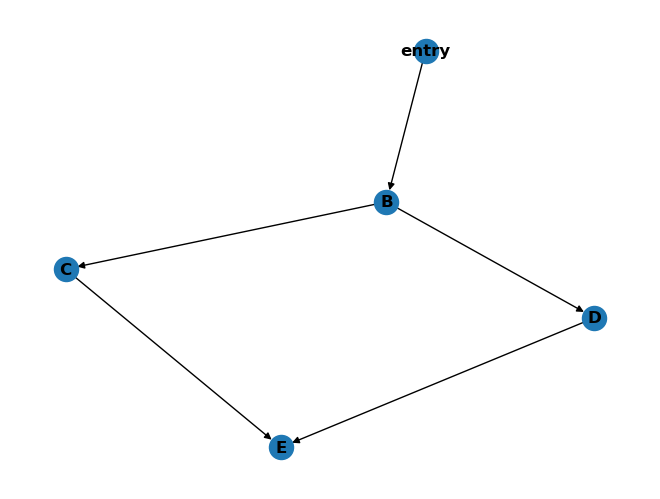

In [21]:
nx.draw(G, with_labels=True, font_weight='bold')